<a href="https://colab.research.google.com/github/revin357/Car_classifier/blob/master/car_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow_hub
!pip install tf-nightly-gpu
!pip install -q h5py pyyaml

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
#tf.enable_eager_execution()


In [0]:
import tensorflow_hub as hub
from tensorflow.keras import layers




In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [6]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

W0511 15:07:29.378319 139685644244864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
import os
import numpy as np
import PIL.Image as Image

data_root = '../content/gdrive/My Drive/Software Engineering Practice/train'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 8144 images belonging to 196 classes.


In [8]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 196)


In [9]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [10]:
labels_path = '../content/gdrive/My Drive/Software Engineering Practice/training_names.txt'
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_names = imagenet_labels[np.argmax(label_batch, axis=-1)]
predicted_class_names

array(['Acura TSX Sedan 2012', 'Chrysler PT Cruiser Convertible 2008',
       'Hyundai Genesis Sedan 2012', 'Rolls-Royce Phantom Sedan 2012',
       'Dodge Ram Pickup 3500 Quad Cab 2009', 'Jaguar XK XKR 2012',
       'Audi TT Hatchback 2011', 'Chevrolet Avalanche Crew Cab 2012',
       'Honda Odyssey Minivan 2012', 'Tesla Model S Sedan 2012',
       'Buick Regal GS 2012', 'smart fortwo Convertible 2012',
       'Hyundai Azera Sedan 2012', 'Ford GT Coupe 2006',
       'Rolls-Royce Phantom Drophead Coupe Convertible 2012',
       'Audi RS 4 Convertible 2008', 'Acura ZDX Hatchback 2012',
       'Lamborghini Reventon Coupe 2008', 'Chevrolet Corvette ZR1 2012',
       'Ferrari FF Coupe 2012', 'BMW X6 SUV 2012',
       'BMW 1 Series Coupe 2012', 'Geo Metro Convertible 1993',
       'Aston Martin V8 Vantage Convertible 2012',
       'Infiniti G Coupe IPL 2012', 'Toyota Sequoia SUV 2012',
       'Acura RL Sedan 2012', 'Chrysler Sebring Convertible 2010',
       'Lincoln Town Car Sedan 2011', '

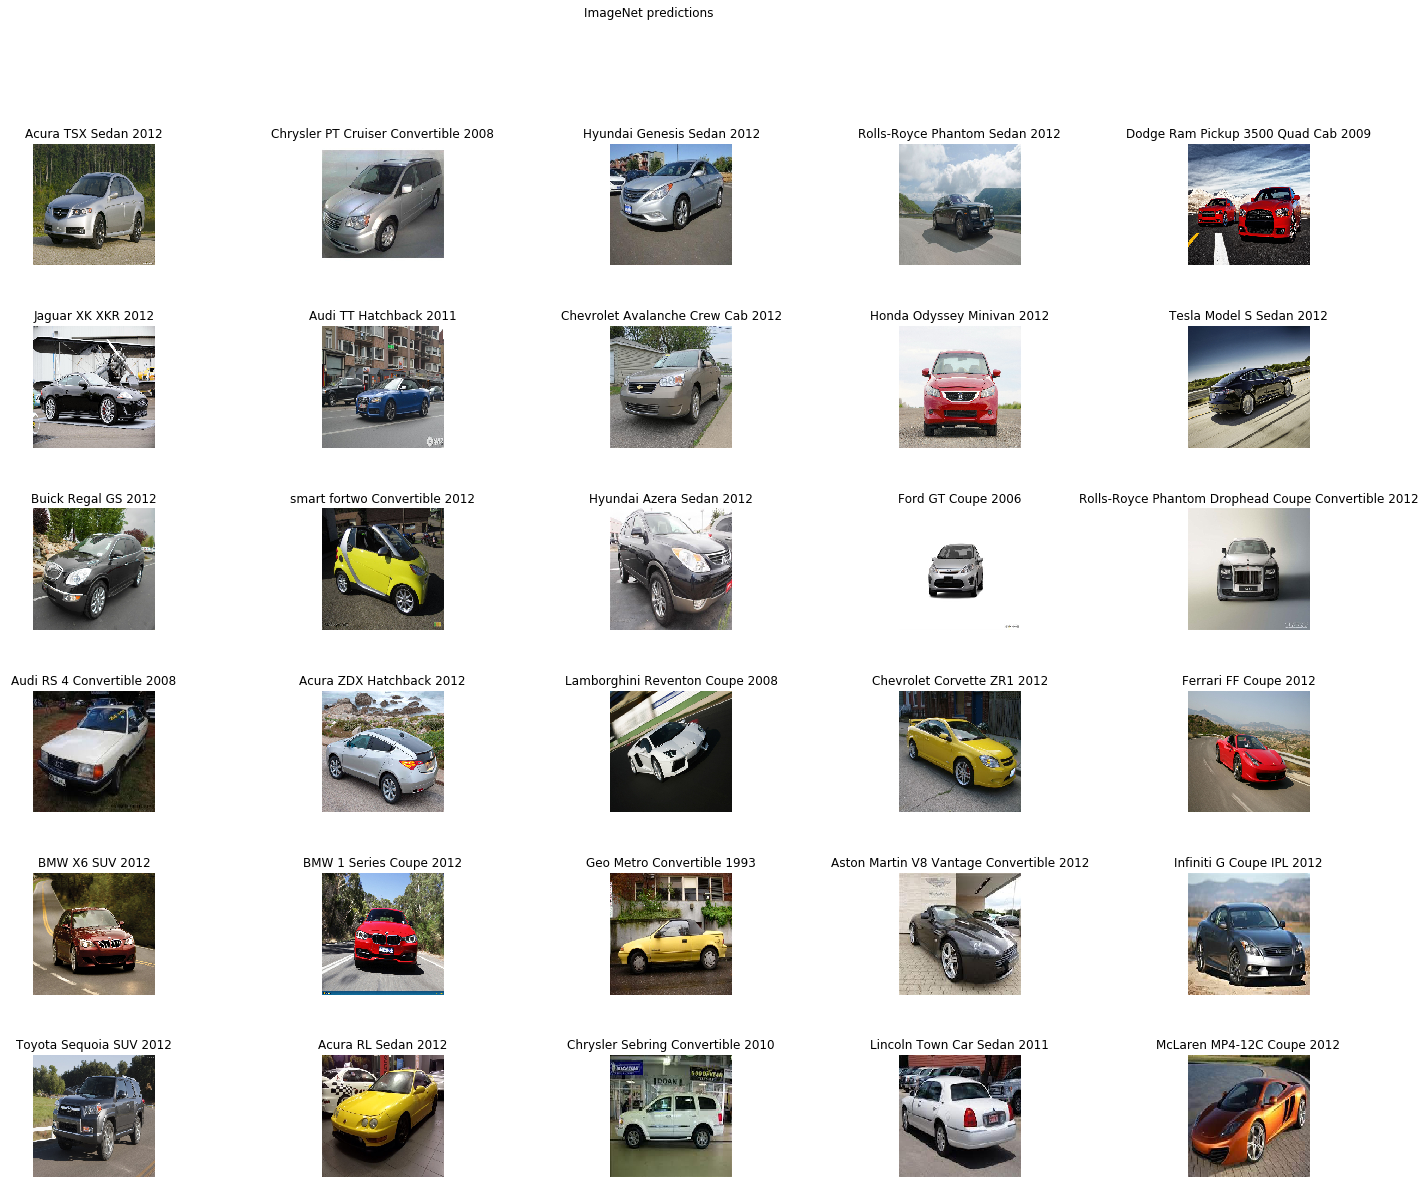

In [11]:
plt.figure(figsize=(25,19))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
  _= plt.suptitle("ImageNet predictions")

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

In [13]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [15]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 196)               251076    
Total params: 2,509,060
Trainable params: 251,076
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
predictions = model(image_batch)

predictions.shape

TensorShape([Dimension(32), Dimension(196)])

In [0]:
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
    metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [20]:
from keras.callbacks import *
from tensorflow.keras.callbacks import *

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats = CollectBatchStats()

import os 
checkpoint_path = "../gdrive/My Drive/Software Engineering Practice/Checkpoints/training_1/cp.ckpt" 

checkpoint_dir = os.path.dirname(checkpoint_path)

 # Create checkpoint  callback 
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
     monitor='acc',save_best_only=True,save_weights_only=True,verbose=1)

history = model.fit(image_data, epochs=11,
                   steps_per_epoch=steps_per_epoch,
                   callbacks = [batch_stats])

model.save('car_classifier_model.h5')

Epoch 1/11
255/255 [==============================] - 891s 3s/step - loss: 4.6608 - acc: 0.2812
Epoch 2/11
255/255 [==============================] - 892s 3s/step - loss: 2.9310 - acc: 0.3438
Epoch 3/11
255/255 [==============================] - 893s 4s/step - loss: 2.1693 - acc: 0.4062
Epoch 4/11
255/255 [==============================] - 889s 3s/step - loss: 1.6990 - acc: 0.5312
Epoch 5/11
255/255 [==============================] - 882s 3s/step - loss: 1.3632 - acc: 0.5625
Epoch 6/11
255/255 [==============================] - 881s 3s/step - loss: 1.1167 - acc: 0.8125
Epoch 7/11
255/255 [==============================] - 864s 3s/step - loss: 0.9263 - acc: 0.7812
Epoch 8/11
255/255 [==============================] - 862s 3s/step - loss: 0.7863 - acc: 0.8125
Epoch 9/11
255/255 [==============================] - 863s 3s/step - loss: 0.6664 - acc: 0.8750
Epoch 10/11
255/255 [==============================] - 867s 3s/step - loss: 0.5848 - acc: 0.8438
Epoch 11/11
255/255 [==================

In [0]:
# Save Model to Google Drive Model Folder
model.save('../content/gdrive/My Drive/Software Engineering Practice/Model/car_classifier_model.h5')

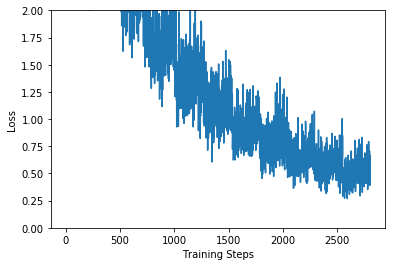

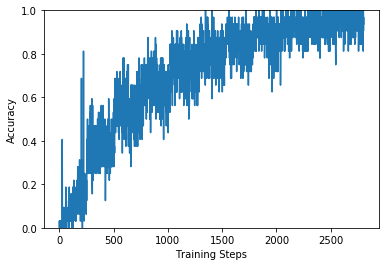

In [23]:
#Plots a graph showing how loss of the model has changed over the training steps
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

#Plots a graph showing how Accuracy of the model has changed over the training steps
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

In [24]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Am General Hummer Suv 2000', 'Acura Integra Type R 2001',
       'Acura Rl Sedan 2012', 'Acura Tl Sedan 2012',
       'Acura Tl Type-S 2008', 'Acura Tsx Sedan 2012',
       'Acura Zdx Hatchback 2012',
       'Aston Martin V8 Vantage Convertible 2012',
       'Aston Martin V8 Vantage Coupe 2012',
       'Aston Martin Virage Convertible 2012',
       'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994',
       'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012',
       'Audi Rs 4 Convertible 2008', 'Audi S4 Sedan 2007',
       'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012',
       'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011',
       'Audi Tt Hatchback 2011', 'Audi Tt Rs Coupe 2012',
       'Audi Tts Coupe 2012', 'Audi V8 Sedan 1994',
       'Bmw 1 Series Convertible 2012', 'Bmw 1 Series Coupe 2012',
       'Bmw 3 Series Sedan 2012', 'Bmw 3 Series Wagon 2012',
       'Bmw 6 Series Convertible 2007', 'Bmw Activehybrid 5 Sedan 2012',
       'Bmw M3 Coupe 2012', 'Bmw

In [25]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Acura Tl Type-S 2008', 'Chrysler Town And Country Minivan 2012',
       'Hyundai Sonata Sedan 2012', 'Rolls-Royce Phantom Sedan 2012',
       'Dodge Charger Srt-8 2009', 'Jaguar Xk Xkr 2012',
       'Audi S5 Convertible 2012', 'Chevrolet Malibu Sedan 2007',
       'Honda Accord Coupe 2012', 'Tesla Model S Sedan 2012',
       'Buick Enclave Suv 2012', 'Smart Fortwo Convertible 2012',
       'Hyundai Veracruz Suv 2012', 'Ford Fiesta Sedan 2012',
       'Rolls-Royce Ghost Sedan 2012', 'Audi 100 Sedan 1994',
       'Acura Zdx Hatchback 2012', 'Lamborghini Aventador Coupe 2012',
       'Chevrolet Cobalt Ss 2010', 'Ferrari 458 Italia Convertible 2012',
       'Bmw M5 Sedan 2010', 'Bmw 3 Series Sedan 2012',
       'Geo Metro Convertible 1993',
       'Aston Martin V8 Vantage Convertible 2012',
       'Infiniti G Coupe Ipl 2012', 'Toyota 4Runner Suv 2012',
       'Acura Integra Type R 2001', 'Chrysler Aspen Suv 2009',
       'Lincoln Town Car Sedan 2011', 'Mclaren Mp4-12C Coupe 2012',


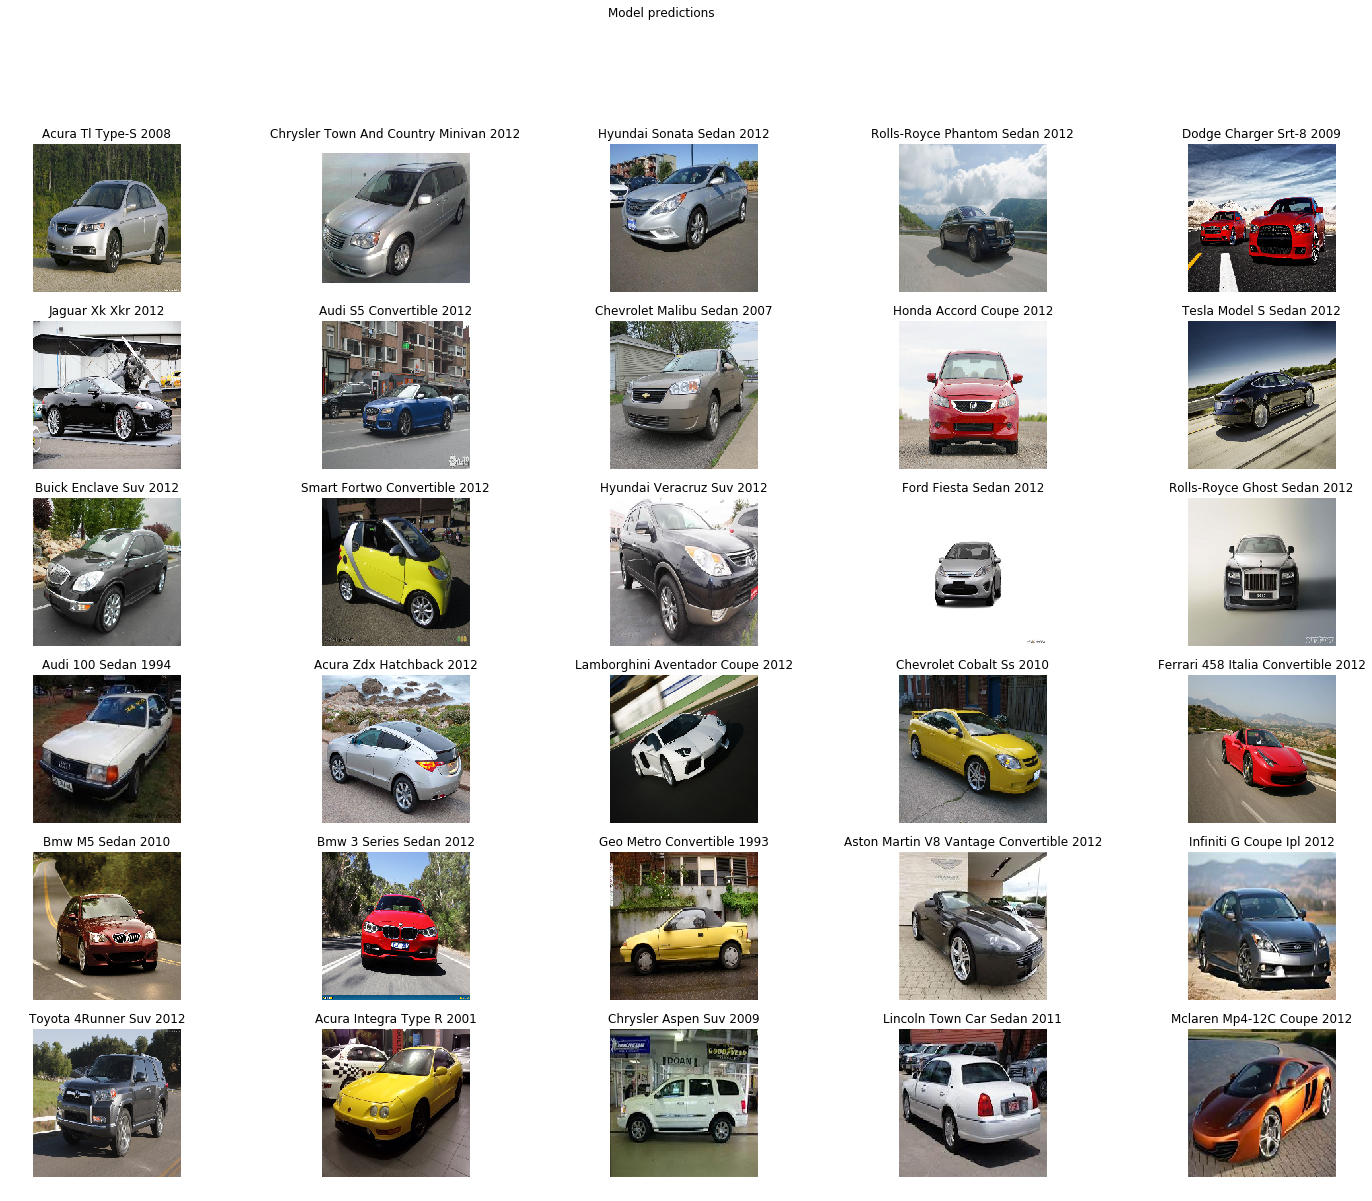

In [28]:
plt.figure(figsize=(25,19))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
  _ = plt.suptitle("Model predictions")